In [47]:
import warnings
from functools import partial

import arviz
import jax
import jax.numpy as jnp
import jax.scipy.stats as jstats
import matplotlib.pyplot as plt
import numpyro
import pandas as pd
import scipy.optimize as opt
import seaborn as sns
from numpyro import distributions as dist
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

In [48]:
@jax.jit
def g(x):
    return -(jnp.sin(6 * jnp.pi * x) ** 2) + 6 * x**2 - 5 * x**4 + 3 / 2


g(1)

Array(2.5, dtype=float32, weak_type=True)

In [49]:
dataset_t = tuple[
    jnp.ndarray, jnp.ndarray, jnp.ndarray, jnp.ndarray, jnp.ndarray, jnp.ndarray
]


# Training set to condition the kernel on, validation set to tune hyperparameters
# / calculate likelihood for mcmc, test set to compare models with
@partial(jax.jit, static_argnums=(0,))
def generate_dataset(number_of_obs=30, key: jnp.ndarray = None) -> dataset_t:
    if key is None:
        key = jax.random.key(0)
    x_data = jnp.linspace(0, 1, number_of_obs)
    y_data = g(x_data) + jax.random.normal(key, x_data.shape) * 0.01
    x_train_valid, x_test, y_train_valid, y_test = train_test_split(
        x_data, y_data, train_size=number_of_obs // 3 * 2, random_state=42
    )
    x_train, x_valid, y_train, y_valid = train_test_split(
        x_train_valid, y_train_valid, train_size=0.6, random_state=42
    )
    return x_train, y_train, x_valid, y_valid, x_test, y_test


generate_dataset(30)

(Array([0.6551724 , 0.3448276 , 1.        , 0.1724138 , 0.10344827,
        0.20689654, 0.37931034, 0.62068963, 0.06896552, 0.7241379 ,
        0.6896552 , 0.03448276], dtype=float32),
 Array([3.0942016 , 2.0757453 , 2.4888556 , 1.6713592 , 0.7148039 ,
        1.2704791 , 1.6844136 , 2.490983  , 0.58994573, 2.4922152 ,
        3.040235  , 1.1502597 ], dtype=float32),
 Array([0.13793103, 0.4827586 , 0.2413793 , 0.55172414, 0.86206895,
        0.7586207 , 0.8965517 , 0.44827586], dtype=float32),
 Array([1.3570876, 2.5320344, 0.8686456, 2.1747959, 2.9203305, 2.3315835,
        2.223386 , 1.8244766], dtype=float32),
 Array([0.9310345 , 0.51724136, 0.79310346, 0.5862069 , 0.27586207,
        0.31034482, 0.9655172 , 0.8275862 , 0.4137931 , 0.        ],      dtype=float32),
 Array([2.0140355, 2.6466045, 2.811917 , 1.9905599, 1.1414744, 1.855348 ,
        2.37807  , 3.241496 , 1.3928322, 1.4971629], dtype=float32))

In [53]:
@partial(jnp.vectorize, signature="(x),(z),(2)->(x,z)")
@jax.jit
def wavy_kernel(x: jnp.ndarray, y: jnp.ndarray, params: jnp.ndarray):
    a, b = params[0], params[1]
    return (1 + x.reshape((-1, 1)) @ y.reshape((1, -1))) ** 2 + a * (
        jnp.sin(2 * jnp.pi * x.flatten() + b).reshape((-1, 1))
        * jnp.sin(2 * jnp.pi * y.flatten() + b).reshape((1, -1))
    )


ex_x = jnp.linspace(0, 1, num=3)
wavy_kernel(ex_x, ex_x, jnp.array([1, 1]))

Array([[1.7080734, 0.2919265, 1.7080735],
       [0.2919265, 2.2705736, 1.5419264],
       [1.7080735, 1.5419264, 4.7080736]], dtype=float32)

In [54]:
@jax.jit
def parameter_prior_wavy(noise_params: jnp.ndarray):
    noise_y, a, b = noise_params[0], noise_params[1], noise_params[2]
    return (
        jstats.expon.logpdf(noise_y)
        + jstats.expon.logpdf(a)
        + jstats.uniform.logpdf(b, loc=0, scale=2 * jnp.pi)
    )

In [55]:
kernel = wavy_kernel
num_kernel_params = 2
ex_params = jnp.array([1, 1])
parameter_prior = parameter_prior_wavy

In [56]:
@partial(jnp.vectorize, signature=f"(t),(t),(s),(),({num_kernel_params})->(s),(s,s)")
@jax.jit
def posterior_conditional(
    x_train: jnp.ndarray,
    y_train: jnp.ndarray,
    x_star: jnp.ndarray,
    noise_y: float,
    params: jnp.ndarray,
):
    inverse_cov = jnp.linalg.inv(
        kernel(x_train, x_train, params) + noise_y * jnp.identity(len(x_train))
    )
    kernel_star = kernel(x_train, x_star, params)
    mu_star = kernel_star.T @ inverse_cov @ y_train
    cov_star = (
        kernel(x_star, x_star, params) - kernel_star.T @ inverse_cov @ kernel_star
    )
    return mu_star, cov_star


posterior_conditional(ex_x, ex_x, ex_x[:2], 0.1, ex_params)

(Array([0.02836096, 0.4943103 ], dtype=float32),
 Array([[ 0.09142661, -0.00116915],
        [-0.0011692 ,  0.09450984]], dtype=float32))

In [78]:
@partial(jax.jit, static_argnames=("use_test_set",))
def log_posterior_prob(
    params: jnp.ndarray, dataset: dataset_t, noise_y=0.01, use_test_set: bool = False
):
    if use_test_set:
        x_train, y_train, _x_valid, _y_valid, x_star, y_star = dataset
    else:
        x_train, y_train, x_star, y_star, _x_test, _y_test = dataset

    mu_star, cov_star = posterior_conditional(x_train, y_train, x_star, noise_y, params)
    cov = cov_star + noise_y * jnp.identity(len(mu_star))
    logpdf = jstats.multivariate_normal.logpdf(y_star, mean=mu_star, cov=cov)
    prior = parameter_prior(params)
    return jnp.nan_to_num(logpdf + prior, nan=-jnp.inf)


log_posterior_prob(ex_params, generate_dataset(30))

Array(-44.78116, dtype=float32)

In [79]:
def grid_search(
    search_ranges: tuple[tuple[float, float], ...], grid_size: int, dataset: dataset_t
):
    opt_params = opt.brute(
        lambda p: -log_posterior_prob(p, dataset),
        search_ranges,
        Ns=grid_size,
        finish=None,
    )
    return opt_params

In [80]:
ex_dataset = generate_dataset()

In [86]:
found_params = grid_search(
    search_ranges=((0, 2), (0, 2 * jnp.pi)),
    grid_size=300,
    dataset=ex_dataset,
)
found_params

array([0.10702341, 0.46230795])

In [87]:
log_posterior_prob(found_params, ex_dataset, use_test_set=True)

Array(-76.760254, dtype=float32)

In [88]:
class KernelProbDensity(dist.Distribution):
    support = dist.constraints.interval(-3, 3)
    arg_constraints = {"start": support}  # noqa: RUF012

    def __init__(self, dataset: dataset_t, start: jnp.ndarray = None):
        if start is None:
            start = ex_params
        assert start.shape == (num_kernel_params,), start.shape
        self.start = start
        self.dataset = dataset
        super().__init__(event_shape=(num_kernel_params,))

    def sample(self, _key, sample_shape=()):
        return jnp.full(sample_shape, self.start)

    def log_prob(self, value):
        assert value.shape == (
            num_kernel_params,
        ), f"{value.shape=} {num_kernel_params=}"
        return log_posterior_prob(value, self.dataset)

In [89]:
def mcmc_kernel_model(dataset: dataset_t):
    return numpyro.sample("noise_params", KernelProbDensity(dataset))

In [90]:
warnings.filterwarnings(
    "ignore", message="There are not enough devices to run parallel chains"
)

In [91]:
nuts_kernel = numpyro.infer.NUTS(mcmc_kernel_model)
ex_mcmc = numpyro.infer.MCMC(
    nuts_kernel, num_samples=3_000, num_chains=8, num_warmup=2000, progress_bar=True
)
ex_mcmc.run(jax.random.key(1), ex_dataset)

sample: 100%|██████████| 5000/5000 [00:01<00:00, 3628.82it/s, 31 steps of size 9.00e-02. acc. prob=0.82]


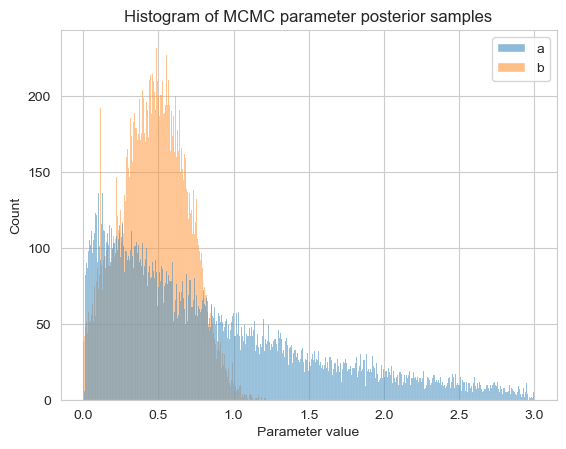

In [93]:
samples: jnp.ndarray = ex_mcmc.get_samples()["noise_params"]
sns.histplot(pd.DataFrame(samples, columns=["a", "b"]), binwidth=0.005).set(
    xlabel="Parameter value", title="Histogram of MCMC parameter posterior samples"
)
plt.show()

In [94]:
arv = arviz.from_dict(ex_mcmc.get_samples(group_by_chain=True))
summ = arviz.summary(arv)
summ.index = ["a", "b"]
summ

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.844,0.69,0.010,2.195,0.016,0.011,1785.0,1822.0,1.01
b,0.471,0.22,0.052,0.855,0.005,0.003,2234.0,3907.0,1.00


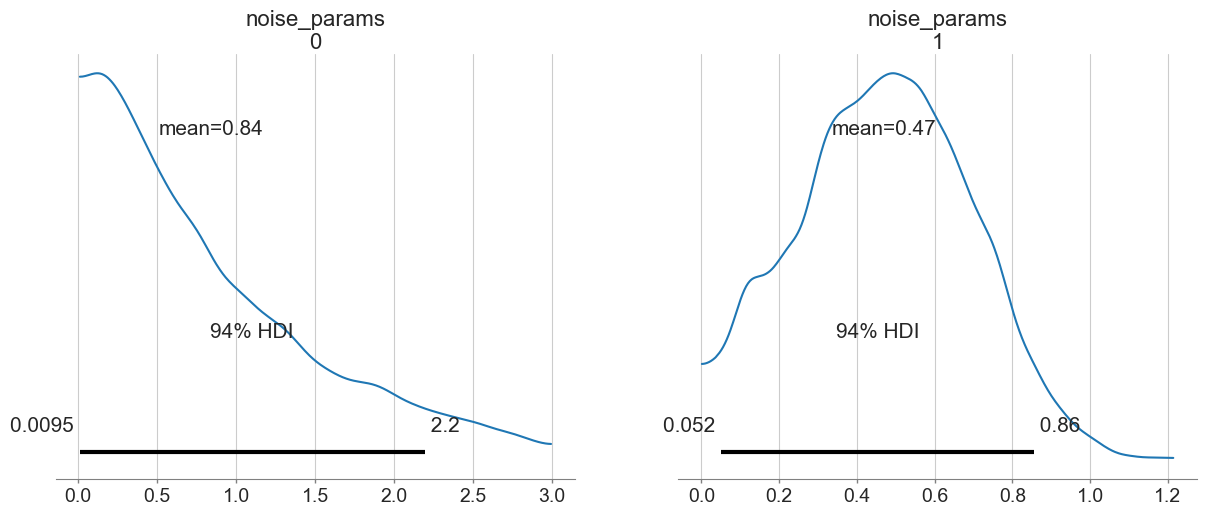

In [95]:
arviz.plot_posterior(arv)
plt.show()

In [97]:
ex_strided_post_samples = ex_mcmc.get_samples(group_by_chain=True)[
    "noise_params"
].reshape((-1, 2))[:: 8 * 6]
ex_strided_post_samples.shape

(500, 2)

In [98]:
def approx_posterior(posterior_samples: jnp.ndarray, dataset: dataset_t):
    return jax.vmap(partial(log_posterior_prob, dataset=dataset, use_test_set=True))(
        posterior_samples
    )


approx_posterior(ex_strided_post_samples, ex_dataset).mean()

Array(-78.65895, dtype=float32)

In [130]:
def repeat_estimate(key: jnp.ndarray = None, n_times: int = 20, n_obs: int = 30):
    if key is None:
        key = jax.random.key(42)

    map_likelihoods = []
    mcmc_likelihoods = []

    bar = tqdm(jax.random.split(key, n_times), desc="Repeated estimation")
    for iter_key in bar:
        data_key, mcmc_key = jax.random.split(iter_key)
        dataset = generate_dataset(number_of_obs=n_obs, key=data_key)
        map_params = grid_search(
            search_ranges=((-1, 1), (0, 2 * jnp.pi)),
            grid_size=300,
            dataset=ex_dataset,
        )
        map_likelihoods.append(
            log_posterior_prob(map_params, dataset, use_test_set=True)
        )

        mcmc = numpyro.infer.MCMC(
            nuts_kernel,
            num_samples=3_000,
            num_chains=8,
            num_warmup=2_000,
            progress_bar=False,
        )
        mcmc.run(mcmc_key, dataset)
        strided_samples = mcmc.get_samples(group_by_chain=True)["noise_params"].reshape(
            (-1, 3)
        )[:: 8 * 6]
        mcls = approx_posterior(strided_samples, dataset)
        mcl = jnp.nanmean(mcls, where=mcls > -1e5)
        mcmc_likelihoods.append(mcl)
        bar.set_postfix(mcl=mcl)

    return jnp.array(map_likelihoods), jnp.array(mcmc_likelihoods)

In [131]:
map_ls, mcmc_ls = repeat_estimate()

Repeated estimation:   0%|          | 0/20 [00:00<?, ?it/s]

In [132]:
print(f"MAP likelhoods:  \tmean {map_ls.mean()}, \tstd: {map_ls.std()}")
print(f"MCMC likelhoods: \tmean {mcmc_ls.mean()}, \tstd: {mcmc_ls.std()}")

MAP likelhoods:  	mean -80.6949462890625, 	std: 1.4820791482925415
MCMC likelhoods: 	mean -81.43738555908203, 	std: 1.5941925048828125


In [133]:
map_ls, mcmc_ls

(Array([-80.50669 , -80.88887 , -81.2008  , -79.37124 , -77.4823  ,
        -79.350044, -82.66865 , -79.86621 , -80.78842 , -80.22524 ,
        -83.344315, -79.36245 , -79.79477 , -80.41877 , -81.53546 ,
        -82.19196 , -83.2183  , -79.14355 , -80.07817 , -82.46275 ],      dtype=float32),
 Array([-80.88577 , -82.164154, -82.194   , -79.55256 , -78.804214,
        -79.726685, -83.003265, -81.026886, -81.32177 , -80.868576,
        -84.44162 , -79.926285, -80.93972 , -81.52432 , -81.35621 ,
        -83.079185, -84.87541 , -79.278625, -80.91472 , -82.8637  ],      dtype=float32))